# Objective: fine-tuning DETR

-   Original notebook: https://github.com/woctezuma/finetune-detr
-   Official DETR repository: https://github.com/facebookresearch/detr
-   Discussion about facebook DETR fine-tuning in [a Github issue](https://github.com/facebookresearch/detr/issues/9).

## Define useful boilerplate functions

Adapted from:
-   https://github.com/woctezuma/finetune-detr/blob/master/finetune_detr.ipynb
-   https://colab.research.google.com/github/facebookresearch/detr/blob/colab/notebooks/detr_attention.ipynb

In [1]:
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())

torch.set_grad_enabled(False);

1.7.0 True


In [2]:
import torchvision.transforms as T

# standard PyTorch mean-std input image normalization
transform = T.Compose([
    T.Resize(800),
    T.ToTensor(),
    T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# for output bounding box post-processing
def box_cxcywh_to_xyxy(x):
    x_c, y_c, w, h = x.unbind(1)
    b = [(x_c - 0.5 * w), (y_c - 0.5 * h),
         (x_c + 0.5 * w), (y_c + 0.5 * h)]
    return torch.stack(b, dim=1)

def rescale_bboxes(out_bbox, size):
    img_w, img_h = size
    b = box_cxcywh_to_xyxy(out_bbox)
    b = b * torch.tensor([img_w, img_h, img_w, img_h], dtype=torch.float32)
    return b

In [5]:
def filter_bboxes_from_outputs(outputs,
                               threshold=0.7):
  
    # keep only predictions with confidence above threshold
    probas = outputs['pred_logits'].softmax(-1)[0, :, :-1]
    keep = probas.max(-1).values > threshold

    probas_to_keep = probas[keep]

    # convert boxes from [0; 1] to image scales
    bboxes_scaled = rescale_bboxes(outputs['pred_boxes'][0, keep], im.size)
  
    return probas_to_keep, bboxes_scaled

In [3]:
# COCO classes
CLASSES = [
    'N/A', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A',
    'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse',
    'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack',
    'umbrella', 'N/A', 'N/A', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis',
    'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove',
    'skateboard', 'surfboard', 'tennis racket', 'bottle', 'N/A', 'wine glass',
    'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich',
    'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake',
    'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table', 'N/A',
    'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard',
    'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A',
    'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier',
    'toothbrush'
]

# colors for visualization
COLORS = [[0.000, 0.447, 0.741], [0.850, 0.325, 0.098], [0.929, 0.694, 0.125],
          [0.494, 0.184, 0.556], [0.466, 0.674, 0.188], [0.301, 0.745, 0.933]]

In [54]:
import matplotlib.pyplot as plt

def plot_results(pil_img, prob=None, boxes=None):
    plt.figure(figsize=(10,8))
    plt.imshow(pil_img)
    ax = plt.gca()
    colors = COLORS * 100
    if prob is not None and boxes is not None:
        for p, (xmin, ymin, xmax, ymax), c in zip(prob, boxes.tolist(), colors):
            ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                    fill=False, color=c, linewidth=3))
            cl = p.argmax()
            text = f'{CLASSES[cl]}: {p[cl]:0.2f}'
            ax.text(xmin, ymin, text, fontsize=15,
                  bbox=dict(facecolor='yellow', alpha=0.5))
    plt.axis('off')
    plt.show()

## Load an image for a demo

In [6]:
model = torch.hub.load('facebookresearch/detr', 'detr_resnet50', pretrained=True)
model.eval();

Using cache found in C:\Users\Usuario/.cache\torch\hub\facebookresearch_detr_master


In [56]:
from PIL import Image
import requests

url = 'http://images.cocodataset.org/train2017/000000310645.jpg'
im = Image.open(requests.get(url, stream=True).raw)

In [8]:
# mean-std normalize the input image (batch-size: 1)
img = transform(im).unsqueeze(0)

# propagate through the model
outputs = model(img)

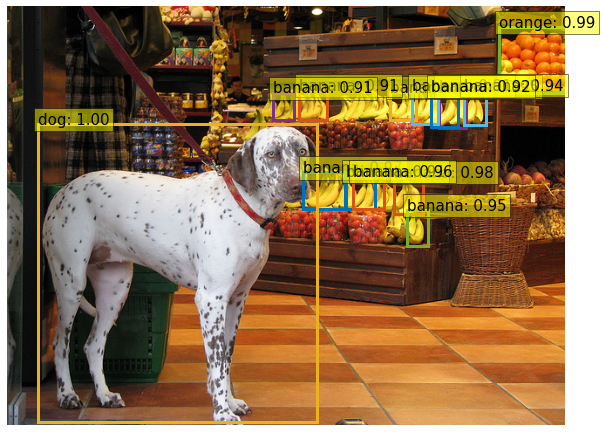

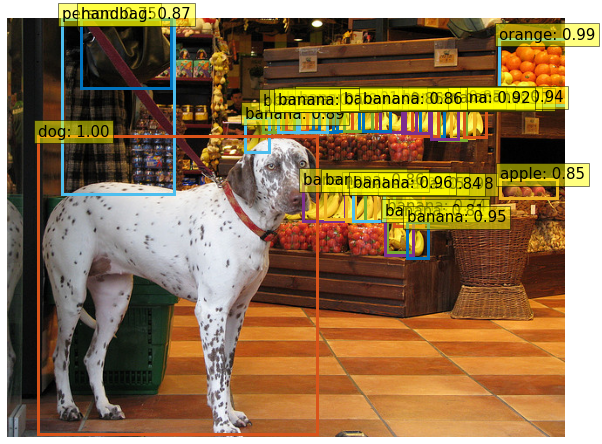

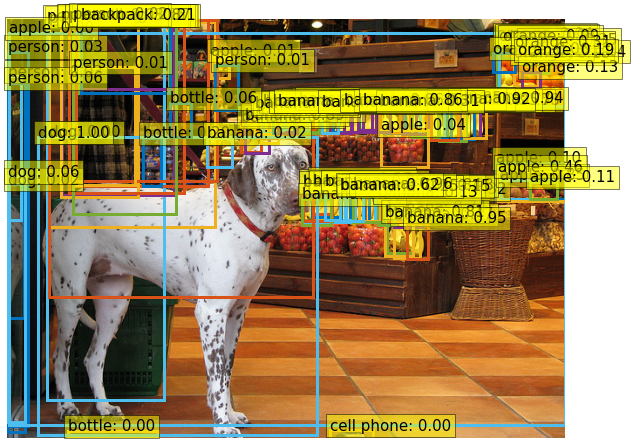

In [57]:
for threshold in [0.9, 0.7, 0.0]:
  
    probas_to_keep, bboxes_scaled = filter_bboxes_from_outputs(outputs,
                                                              threshold=threshold)

    plot_results(im, probas_to_keep, bboxes_scaled)

NB: if the threshold is equal to zero, then you will see all of the 100 query slots. The zero-threshold is only used for illustration. In usual cases, most query slots have a low confidence score, so that irrelevant query slots would be pruned with a higher threshold, such as 0.7 or 0.9.

Reference: https://github.com/facebookresearch/detr/issues/9#issuecomment-635357693

NB²: For fine-tuning purposes, we cannot change the number of query slots.

> If you're fine-tuning, I don't recommend changing the number of queries on the fly, it is extremely unlikely to work out of the box. In this case you're probably better off retraining from scratch (you can change the --num_queries arg from our training script).

Reference: https://github.com/facebookresearch/detr/issues/9#issuecomment-636407752

## Clone a custom code of DETR

Clone [my fork](https://github.com/woctezuma/detr/tree/finetune) tailored for a custom dataset:
-   called `custom`,
-   with `max_class_id = 2` ([explanation](https://github.com/facebookresearch/detr/issues/108#issuecomment-650269223)).

**Caveat**: if you later use `first_class_index = 1` for your dataset, then it is fine. However, if you later use `first_class_index = 0`, then you will have to override the value of `max_class_id` (so that it is equal to 1) when calling `!python main.py`.
```{bash}
git clone https://github.com/woctezuma/detr.git
```

## Load pre-trained weights

Load a check-point (urls can be found [here](https://github.com/facebookresearch/detr#model-zoo)), then remove the classification head.

In [10]:
# Get pretrained weights
checkpoint = torch.hub.load_state_dict_from_url(
            url='https://dl.fbaipublicfiles.com/detr/detr-r50-e632da11.pth',
            map_location='cpu',
            check_hash=True)

# Remove class weights
del checkpoint["model"]["class_embed.weight"]
del checkpoint["model"]["class_embed.bias"]

# Save
torch.save(checkpoint,
           'detr-r50_no-class-head.pth')

## Prepare the dataset for fine-tuning

The `red_panda` and `mouse` dataset will be used. It can be downloaded here [**Open Images V6**](https://storage.googleapis.com/openimages/web/index.html) with all dataset. To select a dataset subset install OIDV6.
```{bash}
pip install oidv6
``` 
So use specific commands with oidv6 at the conda prompt, like this.
```{bash}
oidv6 downloader en --dataset TransformerDataset\ --type_data train --classes "Red panda" --limit 300 --yes
oidv6 downloader en --dataset TransformerDataset\ --type_data train --classes "Mouse" --limit 300 --yes
```
Own dataset has 300 images of red pandas and 300 images of mouse. To convert into COCO json format, we use a [Roboflow](https://app.roboflow.com/) web. It's allow convert 1000 images and anotation in other formats free.

You can choose whether to start indexing categories with 0 or with 1.

This is a matter of taste, and it should not impact the performance of the algorithm.

## Check the dataset after it was pre-processed for fine-tuning

To verify the data loading is correct, let's visualize the annotations of randomly selected samples in the training set:
-   Demo of COCO API: https://github.com/cocodataset/cocoapi/blob/master/PythonAPI/pycocoDemo.ipynb

In [11]:
%matplotlib inline
import pycocotools.coco as coco
from pycocotools.coco import COCO
import numpy as np
import skimage.io as io
import matplotlib.pyplot as plt
import pylab
pylab.rcParams['figure.figsize'] = (10.0, 8.0)

In [12]:
dataDir='VIA2COCO/train/'
annFile='{}_annotations.coco.json'.format(dataDir)

In [13]:
# initialize COCO api for instance annotations
coco=COCO(annFile)

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


In [14]:
# display COCO categories and supercategories
cats = coco.loadCats(coco.getCatIds())

nms=[cat['name'] for cat in cats]
print('Categories: {}'.format(nms))

nms = set([cat['supercategory'] for cat in cats])
print('Super-categories: {}'.format(nms))

Categories: ['Redpandas-and-mouse', 'mouse', 'red_panda']
Super-categories: {'Redpandas-and-mouse', 'none'}


In [15]:
# load and display image
catIds = coco.getCatIds(catNms=['red_panda']);
imgIds = coco.getImgIds(catIds=catIds );

Image n°483
Image name: VIA2COCO/train/425edb67d56afb61_jpg.rf.3644480d926404830302b5db29d371fe.jpg


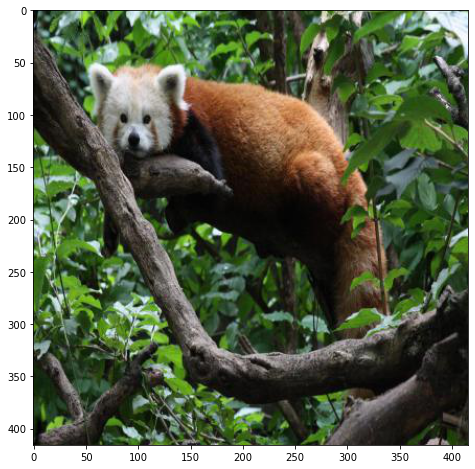

In [17]:
img_id = imgIds[np.random.randint(0,len(imgIds))]
print('Image n°{}'.format(img_id))

img = coco.loadImgs(img_id)[0]

img_name = '%s%s'%(dataDir, img['file_name'])
print('Image name: {}'.format(img_name))

I = io.imread(img_name)
plt.figure()
plt.imshow(I)

In [18]:
annIds = coco.getAnnIds(imgIds=img['id'], catIds=catIds)
anns = coco.loadAnns(annIds)

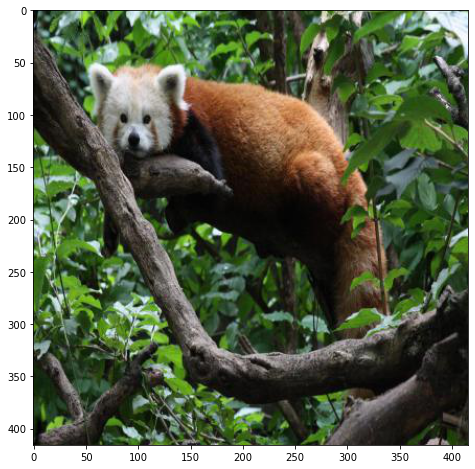

In [19]:
# We do not have area annotations.
plt.imshow(I)
coco.showAnns(anns, draw_bbox=False)

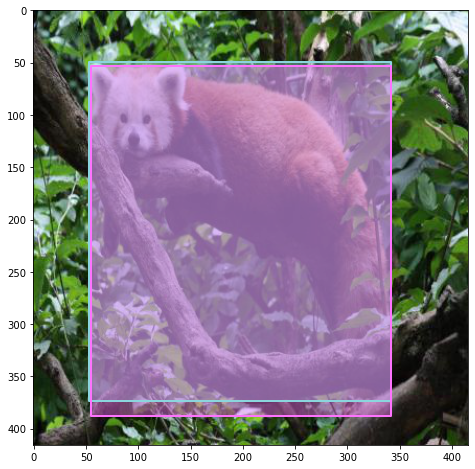

In [20]:
plt.imshow(I)
coco.showAnns(anns, draw_bbox=True)

## Fine-tuning

-   Instructions appear in [a Github Gist](https://gist.github.com/woctezuma/e9f8f9fe1737987351582e9441c46b5d).

NB: There is a `--frozen_weights` argument. However,
i) I have yet to figure out how it is used,
ii) it is of no use for box detection. Indeed, "frozen training is meant for segmentation only" (as mentioned at this [line](https://github.com/facebookresearch/detr/blob/f4cdc542de34de771da8b9189742e5465f5220cd/main.py#L110) of the source-code).

### Boilerplate variables

**Caveat**: the parameter name `num_classes` is misleading. It is actually the ID which DETR will reserve for **its own** `no_object` class.

It should be set to one plus the highest class ID in your dataset.

For instance, if you have one class (balloon):
- if you used the index n°0 for this class, then `max_id = 0` and `num_classes = max_id+1 = 1`
- if you used the index n°1 for this class, then `max_id = 1` and `num_classes = max_id+1 = 2`

Reference: https://github.com/facebookresearch/detr/issues/108#issuecomment-650269223

In [42]:
# However, DETR assumes that indexing starts with 0, as in computer science,
# so there is a dummy class with ID n°0.
# Caveat: this dummy class is not the `no_object` class reserved by DETR.
num_classes = 3
finetuned_classes = [
    'N/A', 'mouse','red_panda'
]
# The `no_object` class will be automatically reserved by DETR with ID equal
# to `num_classes`, so ID n°2 here.

print('Parameter num_classes: {}'.format(num_classes))
print('Fine-tuned classes: {}'.format(finetuned_classes))

Parameter num_classes: 3
Fine-tuned classes: ['N/A', 'mouse', 'red_panda']


**Caveat**: below, we override the value of `num_classes` (hard-coded to 2 for the `custom` dataset in my `finetune` branch of DETR) in case `first_class_index = 0` instead of `first_class_index = 1` (default value).

Before training the model, the custom dataset file was modified to adapt it to the paths of our images.

To train the dataset we use a this command in anaconda bash. The batch_size was small because we train in local. 
```{bash}
python main.py --dataset_file "custom" --coco_path "train/" --output_dir "outputs" --resume "detr-r50_no-class-head.pth" --num_classes 3 --epochs 50 --batch_size 1
```` 
A image with a final training.
<img src="images/training time.png" width="800">

## Check the results

### Monitoring of training

Reference: https://github.com/lessw2020/Thunder-Detr/blob/master/View_your_training_results.ipynb

In [30]:
from util.plot_utils import plot_logs

from pathlib import Path
import os
print(os.getcwd())

log_directory = [Path('detr/outputs/')]

C:\Users\Usuario\Documents\Python_Scripts\Transformers\finetune-detr-master


As mentioned in the code of [`plot_logs`](https://github.com/facebookresearch/detr/blob/5e66b4cd15b2b182da347103dd16578d28b49d69/util/plot_utils.py#L13):
-   solid lines are training results,
-   dashed lines are validation results.

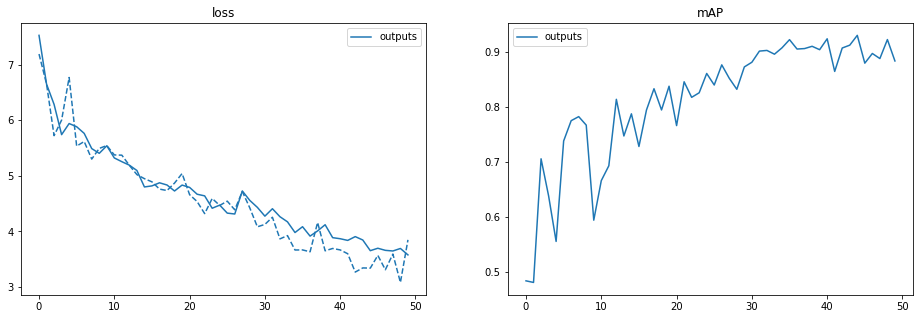

In [31]:
fields_of_interest = (
    'loss',
    'mAP',
    )

plot_logs(log_directory,
          fields_of_interest)

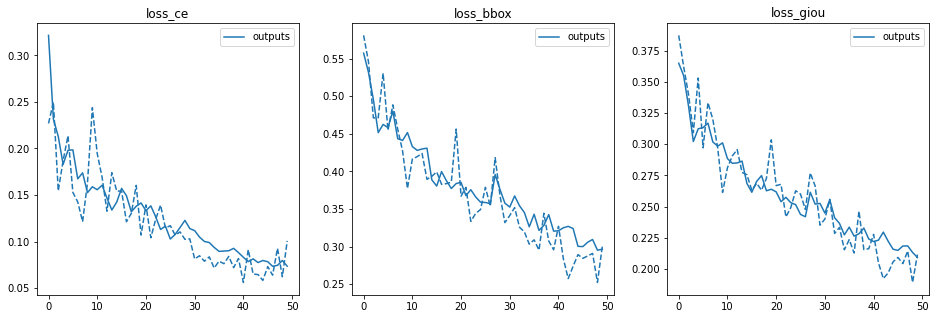

In [32]:
fields_of_interest = (
    'loss_ce',
    'loss_bbox',
    'loss_giou',
    )

plot_logs(log_directory,
          fields_of_interest)

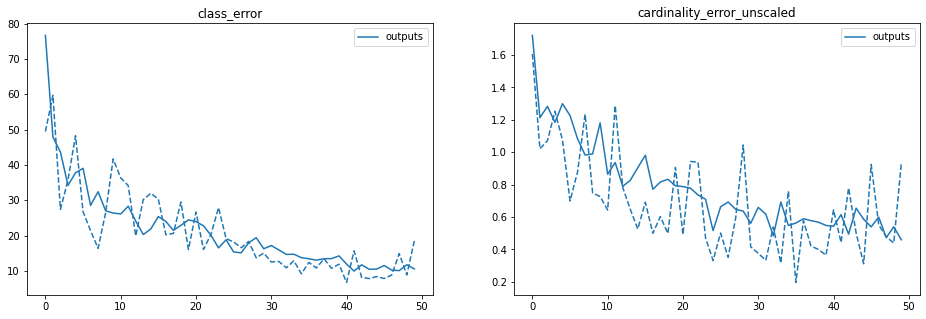

In [33]:
fields_of_interest = (
    'class_error',
    'cardinality_error_unscaled',
    )

plot_logs(log_directory,
          fields_of_interest)   

### Load the fine-tuned model

- How to replace the classification head: https://github.com/facebookresearch/detr/issues/9#issuecomment-636391562

In [34]:
model = torch.hub.load('facebookresearch/detr',
                       'detr_resnet50',
                       pretrained=False,
                       num_classes=num_classes)

checkpoint = torch.load('detr/outputs/checkpoint.pth',
                        map_location='cpu')

model.load_state_dict(checkpoint['model'],
                      strict=False)

model.eval();

Using cache found in C:\Users\Usuario/.cache\torch\hub\facebookresearch_detr_master


### Boilerplate functions to display fine-tuned results

In [45]:
def plot_finetuned_results(pil_img, prob=None, boxes=None):
    plt.figure(figsize=(10,6))
    plt.imshow(pil_img)
    ax = plt.gca()
    colors = COLORS * 100
    if prob is not None and boxes is not None:
        for p, (xmin, ymin, xmax, ymax), c in zip(prob, boxes.tolist(), colors):
            ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                        fill=False, color=c, linewidth=3))
            cl = p.argmax()
            text = f'{finetuned_classes[cl]}: {p[cl]:0.2f}'
            ax.text(xmin, ymin, text, fontsize=15,
                bbox=dict(facecolor='yellow', alpha=0.5))
    plt.axis('off')
    plt.show()

In [38]:
def run_worflow(my_image, my_model):
  # mean-std normalize the input image (batch-size: 1)
    img = transform(my_image).unsqueeze(0)

  # propagate through the model
    outputs = my_model(img)

    for threshold in [0.9, 0.7]:
        probas_to_keep, bboxes_scaled = filter_bboxes_from_outputs(outputs,
                                                              threshold=threshold)
        plot_finetuned_results(my_image,
                               probas_to_keep, 
                               bboxes_scaled)


### With a training image

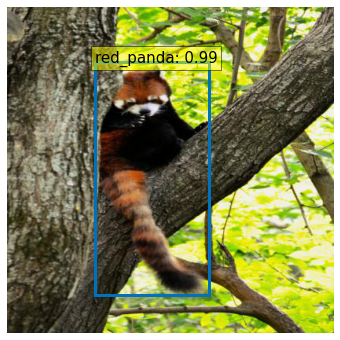

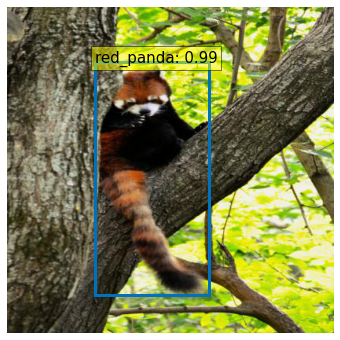

In [46]:
from PIL import Image

img_name = 'pandas rojos y ratones.v1.coco/train/0bf8900576cd5e55_jpg.rf.0ebd34da65cfd623de98ba5b8dfe1605.jpg'
im = Image.open(img_name)

run_worflow(im,
            model)

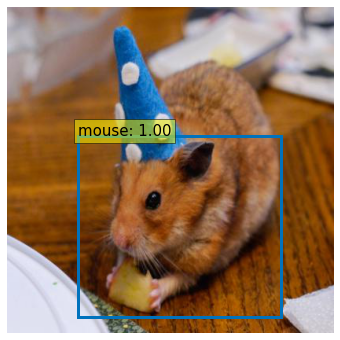

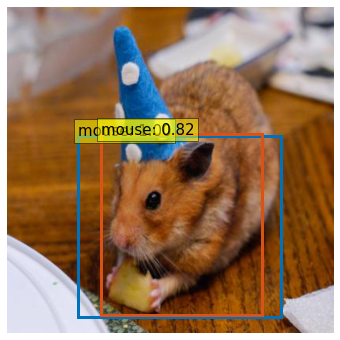

In [47]:
img_name = 'pandas rojos y ratones.v1.coco/train/00e4465db2995332_jpg.rf.5b72e15e857bef1ea0fe8e4d104d83a1.jpg'
im = Image.open(img_name)

run_worflow(im,
            model)

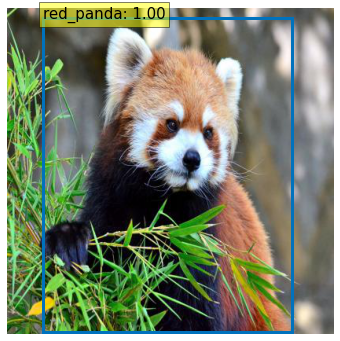

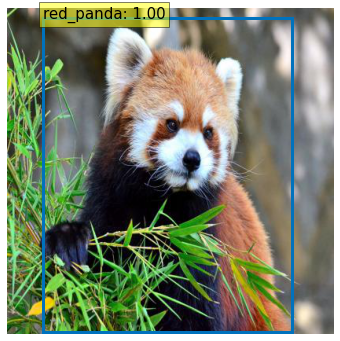

In [53]:
img_name = 'pandas rojos y ratones.v1.coco/train/0cc39456fec6be62_jpg.rf.e3729ab1b381f51c65b4f6438a6bdad8.jpg'
im = Image.open(img_name)

run_worflow(im,
            model)